# Inference
In this notebook we load the pre-trained models, generate some random structures and predict their defect formation energy per site and HOMO-LUMO gap. For magnetic structures, the models predict the minimum of spin-up and spin-down HOMO-LUMO gaps.

In [1]:
%matplotlib widget
from pathlib import Path
import pickle
import yaml
import sys
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from pymatgen.core.structure import Element
sys.path.append("..")
from ai4mat.models.megnet_pytorch.megnet_on_structures import MEGNetOnStructures
from ai4mat.data.data import get_unit_cell, StorageResolver, read_defects_descriptions
from ai4mat.common.sparse_representation import get_sparse_defect, SINGLE_ENENRGY_COLUMN
from ai4mat.common.random_defect_generation import generate_structure_with_random_defects, InconsistentDefectCount
from ai4mat.common.eos import EOS

Load the models

In [2]:
training_experiment = "combined_mixed_all_train"
model_names = {
    "formation_energy_per_site": "megnet_pytorch/sparse/05-12-2022_19-50-53/d6b7ce45",
    "homo_lumo_gap_min": "megnet_pytorch/sparse/05-12-2022_19-50-53/831cc496"}

predictors = dict()
for target, trial_name in model_names.items():
    with open(StorageResolver()["trials"] / f"{trial_name}.yaml", "r") as f:
        config = yaml.safe_load(f)
    predictors[target] = MEGNetOnStructures(config['model_params'])
    predictors[target].load(StorageResolver()["checkpoints"] / training_experiment / target / trial_name / "0.pth",
                            map_location='cpu')

Read the parameters of the experiment that the models were trained on. From them we find out which base materials and point defect types were present in the training set.

In [3]:
experiment_path = StorageResolver()["experiments"].joinpath(training_experiment)
with open(Path(experiment_path, "config.yaml")) as experiment_file:
    experiment_config = yaml.safe_load(experiment_file)
# We don't check how the data are split inside the experiment
# It's the user's responsibility to ensure that the model works on all datasets mentioned
training_datasets = experiment_config["datasets"]

# Computing EOS takes around a minute, so we use the cache
inference_unit_cells_file = StorageResolver()["others"] / "inference_unit_cells_cache.pkl.gz"
unit_cells_loaded = False
try:
    with open(inference_unit_cells_file, 'rb') as f:
        unit_cells, unit_cells_EOS = pickle.load(f)
    unit_cells_loaded = True
    print("Loaded unit cells from cache")
except Exception as inst:
    print(inst)
    print("Can't load unit cells from cache, generating them")
    unit_cells_EOS = dict()
    unit_cells = dict()

defects_list = []
for dataset in tqdm(training_datasets):
    defects = read_defects_descriptions(StorageResolver()["csv_cif"] / dataset)
    materials = defects.base.unique()
    assert len(materials) == 1
    material = materials[0]
    cell = defects.cell.unique()
    assert len(cell) == 1
    cell = cell[0]
    # We have two MoS2/WSe2 unit cells with slightly different height,
    # both are valid and there is no need to include them here
    if not unit_cells_loaded:
        unit_cells[material] = get_unit_cell(StorageResolver()["csv_cif"] / dataset, materials)[material]
        unit_cells_EOS[material] = EOS().get_augmented_struct(unit_cells[material])
    defects_list.append(defects)
if not unit_cells_loaded:
    with open(inference_unit_cells_file, 'wb') as f:
        pickle.dump((unit_cells, unit_cells_EOS), f)
defects_pd = pd.concat(defects_list, axis=0)
if 'pbc' in defects_pd.columns:
    defects_pd = defects_pd.drop(columns=['pbc'])

Loaded unit cells from cache


  0%|          | 0/8 [00:00<?, ?it/s]

With some hashable magic, we get the set of all point defects for each base material

In [4]:
from itertools import chain
from collections import namedtuple
SubstitutionDefect = namedtuple('substitution_defect', ['type', 'from_', 'to'])
VacancyDefect = namedtuple('vacancy_defect', ['type', 'element'])
def to_named_tuple(dict_):
    if dict_['type'] == 'substitution':
        return SubstitutionDefect(dict_['type'], dict_['from'], dict_['to'])
    elif dict_['type'] == 'vacancy':
        return VacancyDefect(**dict_)
    else:
        raise ValueError(f"Unknown defect type {dict_['type']}")
available_defects = defects_pd.groupby(['base', 'cell']).apply(lambda x: set(map(to_named_tuple, chain(*x.defects))))

A lot of code for creating the structure generation interface

In [5]:
reference_supercells = dict()
for material in available_defects.index:
    reference_supercells[material] = unit_cells[material[0]].copy()
    reference_supercells[material].make_supercell(material[1])

In [6]:
material_labels = list(map(lambda x: f"{x[0]}, {x[1][0]}x{x[1][1]} supercell", available_defects.index))

In [28]:
def get_label(defect_tuple):
    if defect_tuple.type == 'substitution':
        return f"{defect_tuple.from_} -> {defect_tuple.to}"
    elif defect_tuple.type == 'vacancy':
        return f"{defect_tuple.element} vacancy"
    else:
        raise ValueError(f"Unknown defect type {defect_tuple.type}")

In [38]:
import matplotlib
import ipywidgets as widgets
from pymatgen.io.ase import AseAtomsAdaptor
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from collections import defaultdict
import io

base_selection = widgets.RadioButtons(options=zip(material_labels, available_defects.index), description='Base material')
total_structures_selection = widgets.IntSlider(min=1, max=100, step=1, value=100)
total_defects_selection = widgets.IntSlider(min=0, max=15, step=1, value=1, description="Total defects")
max_defect_counts_selection = dict()

structure_plots_output = widgets.Output()
rng = np.random.default_rng(42)
image_widget = widgets.Image(format='png', width=700, height=300,
                             layout=widgets.Layout(object_fit='contain'))

def read_max_defect_counts_selection():
    """
    Reads the widget and returns a dict with max defect counts for each defect type
    suitable for the generate_structure_with_random_defects function
    """
    max_defect_counts = defaultdict(dict)
    for defect, count_widget in max_defect_counts_selection.items():
        if defect.type == 'substitution':
            max_defect_counts[defect.from_][defect.to] = count_widget.value
        else:
            max_defect_counts[defect.element]["Vacancy"] = count_widget.value
    return max_defect_counts

def plot_structures():
    base_material = base_selection.value
    max_defect_counts = read_max_defect_counts_selection()
    
    backend = matplotlib.get_backend()
    try:
        matplotlib.use('agg')
        fig, axes = plt.subplots(1, 2, figsize=(7, 3), dpi=300, layout="constrained")
        try:
            example_defect = generate_structure_with_random_defects(total_defects_selection.value, max_defect_counts,
                                                                    reference_supercells[base_material], rng, False)
            atoms = AseAtomsAdaptor.get_atoms(example_defect)
            plot_atoms(atoms, ax=axes[1])
        except InconsistentDefectCount:
            axes[1].text(0.5, 0.5,
                    "Can't generate the requested number of defects,\nincrease the max counts",
                    horizontalalignment='center', verticalalignment='center')
        
        plot_atoms(AseAtomsAdaptor.get_atoms(reference_supercells[base_material]), ax=axes[0])
        axes[0].set_title("Pristine structure")
        axes[1].set_title("Example structure with defects")
        for ax in axes:
            ax.set_axis_off()
        img_buf = io.BytesIO()
        fig.savefig(img_buf, format='png')
        plt.close(fig)
    finally:
        matplotlib.use(backend)
    image_widget.value = img_buf.getvalue()

def prepare_defect_sliders(base_material):
    max_defect_counts_selection.clear()
    for defect in available_defects[base_material]:
        max_defect_counts_selection[defect] = widgets.IntSlider(min=0, max=15, step=1, value=1, description=get_label(defect))
        max_defect_counts_selection[defect].observe(plot_structures_watcher)

    controls.children = [base_selection,
                         total_defects_selection,
                         widgets.Label("Max counts for each defect type:"),
                         *max_defect_counts_selection.values(),
                         widgets.Label("Total structures to generate:"),
                         total_structures_selection]
    plot_structures()

def select_defects(change):
    if change['type'] == 'change' and change['name'] == 'value':
        prepare_defect_sliders(change['owner'].value)

def plot_structures_watcher(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_structures()

base_selection.observe(select_defects)

controls = widgets.VBox([base_selection])
interface = widgets.HBox([controls, image_widget])
prepare_defect_sliders(base_selection.value)
total_defects_selection.observe(plot_structures_watcher)
display(interface)

Once you are happy with the generation options, continue with notebook. Above you should see widgets allowing you to specify the defects to generate. If you don't, you have a problem with [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/). You can specify the parameters below by hand:

In [9]:
base_material = base_selection.value
# material = ('MoS2', (8, 8, 1))
# material should be a tuple of (formula, supercell_size) from available_defects.index
# The models don't generalise to chemically different materials
# Generalising to different supercell sizes is possible but not well tested
if material not in available_defects.index:
    raise ValueError(f"Unknown material {material}, use one in \n{available_defects.index}")

# The number of point defects your structures will have
total_defects = total_defects_selection.value
# total_defects = 3

# The maximum number of each defect type your structures will have
max_defect_counts = read_max_defect_counts_selection()
# max_defect_counts = {'S': {'Se': 1, 'Vacancy': 1}, 'Mo': {'Vacancy': 1, 'W': 1}}

# The number of structures to generate
total_structures = total_structures_selection.value
# total_structures = 100

 Generate the requested number of structures, and plots 5 of them

  0%|          | 0/100 [00:00<?, ?it/s]

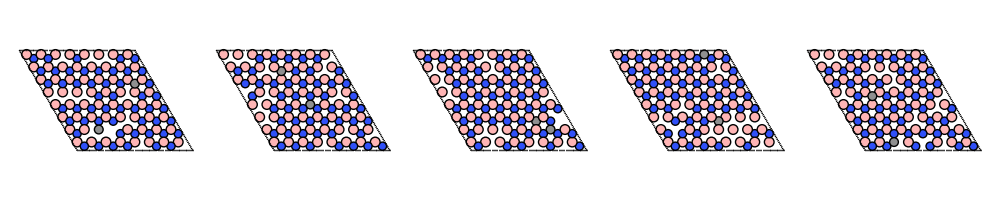

In [23]:
reference_supercell = reference_supercells[base_material]
structures = []
for i in trange(total_structures):
    structures.append(generate_structure_with_random_defects(total_defects, max_defect_counts,
                                                             reference_supercell, rng, False))
    
defects_to_plot = min(5, len(structures))
fig, axes = plt.subplots(1, defects_to_plot, figsize=(defects_to_plot * 2, 2))
for i in range(defects_to_plot):
    atoms = AseAtomsAdaptor.get_atoms(structures[i])
    plot_atoms(atoms, ax=axes[i])
    axes[i].set_axis_off()
fig.tight_layout()

Prepare and plot the sparse structures

  0%|          | 0/100 [00:00<?, ?it/s]

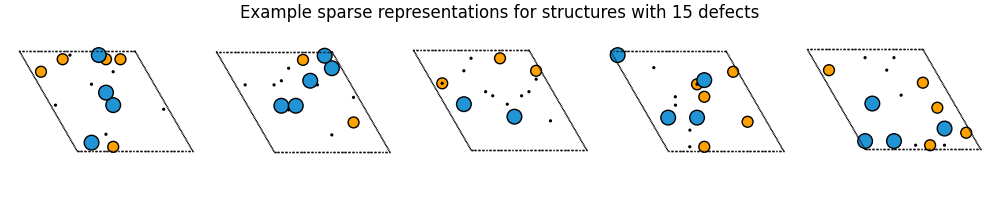

In [11]:
# Prepare dummy single atom energies to get the sparse representation.
# They don't affect the structures, but are required if you ever want to
# compute the total potential energy of the structure, as opposed to the
# formation energy of the defect

# If you want to predict for you own material, you need to provide the


elements = set(map(lambda x: x.specie, reference_supercell))
for defect in available_defects[base_material]:
    if defect.type == 'substitution':
        elements.add(Element(defect.from_))
        elements.add(Element(defect.to))
    else:
        elements.add(Element(defect.element))
single_atom_energies_dummy = pd.DataFrame(data=np.zeros((len(elements),1)), columns=[SINGLE_ENENRGY_COLUMN],
                                          index=np.fromiter(elements, dtype=Element, count=len(elements)))
sparse_structures = []
for structure in tqdm(structures):
    sparse_structures.append(get_sparse_defect(structure, unit_cells_EOS[base_material[0]], base_material[1], single_atom_energies_dummy)[0])
fig, axes = plt.subplots(1, defects_to_plot, figsize=(defects_to_plot * 2, 2))
for i in range(defects_to_plot):
    atoms = AseAtomsAdaptor.get_atoms(sparse_structures[i])
    plot_atoms(atoms, ax=axes[i])
    axes[i].set_axis_off()
fig.tight_layout()
fig.suptitle(f"Example sparse representations for structures with {total_defects} defects");

If you are a reading kind of person, here is a sparse structure

In [12]:
sparse_structures[0]

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999997 22.103155538338676 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
    pbc : True True True
PeriodicSite: X0+ (-4.7727, 10.1232, 3.7198) [0.0420, 0.4580, 0.2500]
PeriodicSite: W (3.1903, 1.8419, 3.7198) [0.1667, 0.0833, 0.2500]
PeriodicSite: X0+ (-1.5824, 21.1748, 3.7198) [0.4170, 0.9580, 0.2500]
PeriodicSite: W (7.9758, 10.1306, 3.7198) [0.5417, 0.4583, 0.2500]
PeriodicSite: W (6.3806, 12.8935, 3.7198) [0.5417, 0.5833, 0.2500]
PeriodicSite: W (4.7855, 21.1822, 3.7198) [0.6667, 0.9583, 0.2500]
PeriodicSite: Se (-7.9758, 17.4983, 2.1549) [0.0833, 0.7917, 0.1448]
PeriodicSite: X0+ (6.3679, 3.6912, 2.1575) [0.3330, 0.1670, 0.1450]
PeriodicSite: X0+ (7.9630, 17.5057, 2.1575) [0.7080, 0.7920, 0.1450]
PeriodicSite: Se (6.3806, 20.2612, 2.1549) [0.7083, 0.9167, 0.1448]
PeriodicSit

In [13]:
predictions = pd.DataFrame(columns=["structure", "sparse_structure"] + list(predictors.keys()))
predictions["structure"] = structures
predictions["sparse_structure"] = sparse_structures
for target, predictor in predictors.items():
    predictions[target] = predictor.predict_structures(sparse_structures)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Let's explore our predictions!

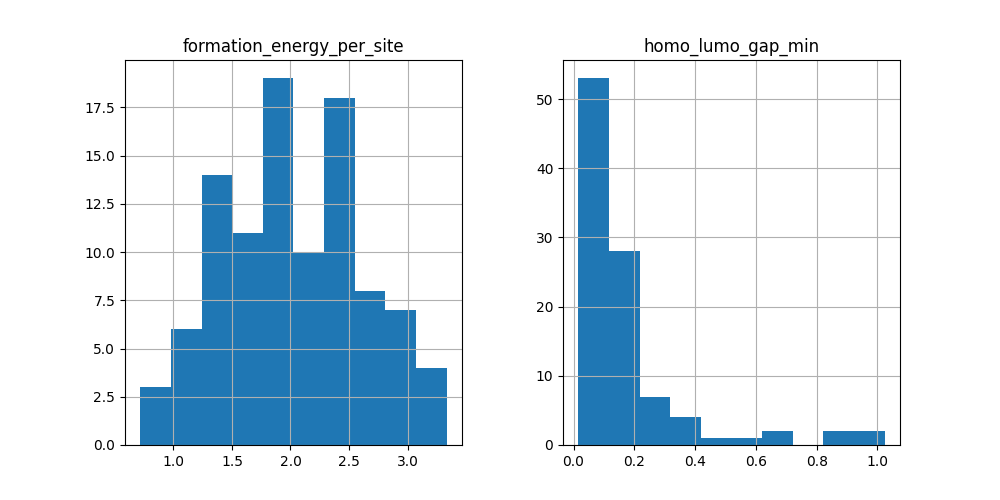

In [14]:
# Both formation energy per site and HOMO-LUMO gap are in eV
predictions.hist(figsize=(10, 5), bins=10);

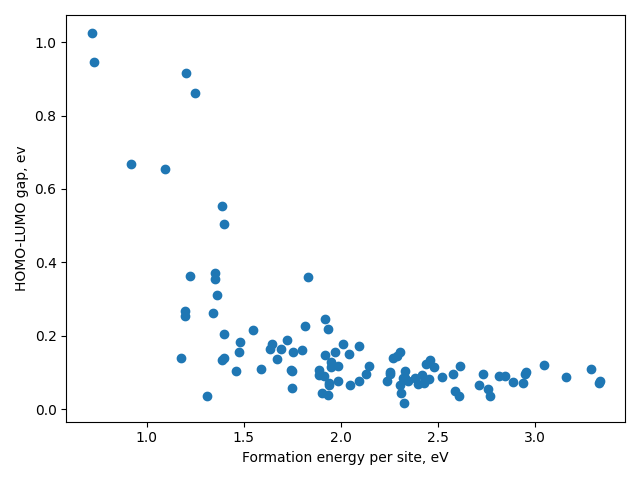

In [15]:
fig, ax = plt.subplots()
ax.scatter(predictions["formation_energy_per_site"], predictions["homo_lumo_gap_min"])
ax.set_xlabel("Formation energy per site, eV")
ax.set_ylabel("HOMO-LUMO gap, ev");
fig.tight_layout()

Let's find and plot structures across the property range

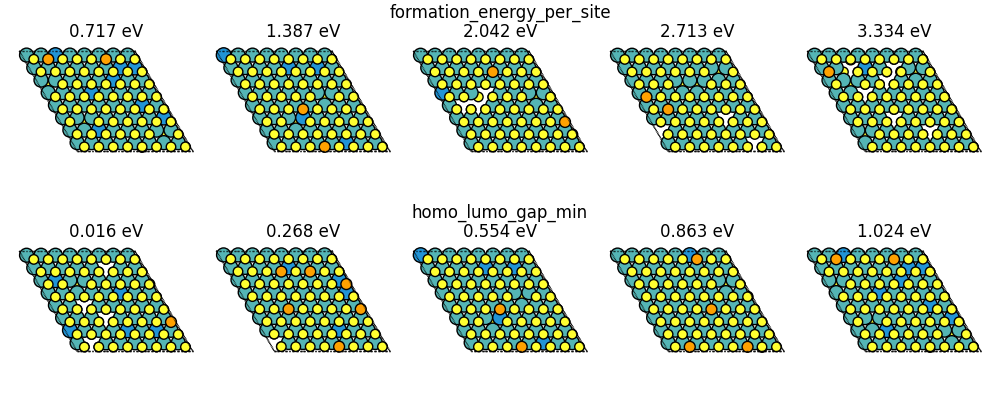

In [16]:
structures_to_plot = 5
fig = plt.figure(figsize=(structures_to_plot*2, len(predictors.keys())*2))
subfigs = fig.subfigures(nrows=len(predictors.keys()), ncols=1)

for target, subfig in zip(predictors.keys(), subfigs):
    sorted_predictions = predictions.sort_values(target, ignore_index=True)
    values_to_plot = np.linspace(sorted_predictions[target].iloc[0], sorted_predictions[target].iloc[-1], num=structures_to_plot)
    
    indices_to_plot = np.searchsorted(sorted_predictions[target], values_to_plot)
    
    subfig.suptitle(target)
    axes = subfig.subplots(nrows=1, ncols=len(indices_to_plot))
    for index, ax in zip(indices_to_plot, axes):
        plot_atoms(AseAtomsAdaptor.get_atoms(sorted_predictions.loc[index, "structure"]), ax=ax)
        ax.set_axis_off()
        ax.set_title(f"{sorted_predictions.loc[index, target]:.3f} eV")
fig.tight_layout()